<a href="https://colab.research.google.com/github/giriragav/UChicago---QCSD/blob/main/Module%203/lab6/lab6_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# @title
!pip install qiskit

In [61]:
# @title Imports
import numpy as np
import networkx as nx
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Qubit
from IPython.display import display

from typing import Dict, Any, List

In [62]:
# @title A test program

# Implementation of the Cuccaro Quantum Adder from
#   https://github.com/jmbaker94/quantumcircuitbenchmarks
# Design from the paper
#   https://arxiv.org/abs/quant-ph/0410184

# Majority gate
maj_c = QuantumCircuit(3, name='MAJ')
maj_c.cx(2, 1)
maj_c.cx(2, 0)
maj_c.ccx(0, 1, 2)
maj = maj_c.to_gate(label='MAJ')
print("MAJ Circuit:")
display(maj_c.draw(fold=-1))

# 2-CNOT version of UnMajority and Add gate
uma2_c = QuantumCircuit(3, name='UMA2')
uma2_c.ccx(0, 1, 2)
uma2_c.cx(2, 0)
uma2_c.cx(0, 1)
uma2 = uma2_c.to_gate(label='UMA2')
print("uma2 Circuit:")
display(uma2_c.draw(fold=-1))

# 3-CNOT version of UnMajority and Add gate
# (Allows more parallelism in the circuit)
uma3_c = QuantumCircuit(3, name='UMA3')
uma3_c.x(1)
uma3_c.cx(0, 1)
uma3_c.ccx(0, 1, 2)
uma3_c.x(1)
uma3_c.cx(2, 0)
uma3_c.cx(2, 1)
uma3 = uma3_c.to_gate(label='UMA3')
print("uma3 Circuit:")
display(uma3_c.draw(fold=-1))


def cuccaro_adder(c, cin, a, b, cout, uma=uma3):
    c.append(maj, [cin, b[0], a[0]])
    for i in range(1, len(b)):
        c.append(maj, [a[i-1], b[i], a[i]])

    c.cx(a[-1], cout)

    for i in reversed(range(1, len(b))):
        c.append(uma, [a[i-1], b[i], a[i]])
    c.append(uma, [cin, b[0], a[0]])

def generate_adder_circuit(n, uma=uma3):
    if n % 2 != 0:
        raise ValueError('Odd number of qubits')

    qubits = QuantumRegister
    cin = range(1)
    a = range(1, n//2)
    b = range(n//2, n-1)
    cout = range(n-1, n)
    c = QuantumCircuit(n)

    cuccaro_adder(c, cin, a, b, cout, uma=uma)
    return c

def decomposed_adder_circuit(n):
    return qiskit.transpile(generate_adder_circuit(n),
                            basis_gates=['cx', 'rx', 'h', 'rz'])

print('Cuccaro Adder:')
display(generate_adder_circuit(4).draw(fold=-1))
cuccaro = decomposed_adder_circuit(4)
cuccaro.draw(fold=-1)

MAJ Circuit:


┌───┐     
q_0: ─────┤ X ├──■──
     ┌───┐└─┬─┘  │  
q_1: ┤ X ├──┼────■──
     └─┬─┘  │  ┌─┴─┐
q_2: ──■────■──┤ X ├
               └───┘

uma2 Circuit:


┌───┐     
q_0: ──■──┤ X ├──■──
       │  └─┬─┘┌─┴─┐
q_1: ──■────┼──┤ X ├
     ┌─┴─┐  │  └───┘
q_2: ┤ X ├──■───────
     └───┘

uma3 Circuit:


┌───┐     
q_0: ───────■────■───────┤ X ├─────
     ┌───┐┌─┴─┐  │  ┌───┐└─┬─┘┌───┐
q_1: ┤ X ├┤ X ├──■──┤ X ├──┼──┤ X ├
     └───┘└───┘┌─┴─┐└───┘  │  └─┬─┘
q_2: ──────────┤ X ├───────■────■──
               └───┘

Cuccaro Adder:


┌──────┐     ┌───────┐
q_0: ┤0     ├─────┤0      ├
     │      │     │       │
q_1: ┤2 MAJ ├──■──┤2 UMA3 ├
     │      │  │  │       │
q_2: ┤1     ├──┼──┤1      ├
     └──────┘┌─┴─┐└───────┘
q_3: ────────┤ X ├─────────
             └───┘

global phase: 5π/4
          ┌───┐                                                                            ┌─────────┐                                                                                                              ┌───┐       
q_0: ─────┤ X ├────────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/2) ├───────────────────────────────────────■────────────────────────────────■───────────────■────────────────■────┤ X ├───────
          └─┬─┘┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  └──┬───┬──┘               ┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │     ┌───┐      │    └─┬─┘       
q_1: ──■────■──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├───────────────■──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├──────┼──────■──────■──
     ┌─┴─┐     └───┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐┌──┴───┴───┐┌───────┐  │  └───┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐┌──┴───┴───┐┌─┴─┐┌───────┐┌─┴─┐
q_2: ┤ X ├────────────■────────────────────────────────■──┤ Rz(π/4) ├─────────────────┤ X ├┤ Rz(-π/4) ├┤ Rx(π) ├──┼─────────■────────────────────────────────■──┤ Rz(π/4) ├─────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rx(π) ├┤ X ├
     └───┘                                                └─────────┘                 └───┘└──────────┘└───────┘┌─┴─┐                                           └─────────┘                 └───┘└──────────┘└───┘└───────┘└───┘
q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                └───┘

In [63]:
# @title Data classes and help functions
# 0.2.0 Wrapping Gates to Make them hashable in a graph structure and give them a unique identifying label
import dataclasses
@dataclasses.dataclass
class GateWrapper:
    gate:Any
    qubits:List[Qubit]
    extra_params:List[Any]
    label:str

    def __hash__(self):
        return hash((type(self.gate), tuple(self.qubits), self.label))

    def __str__(self):
        args = ','.join(str(q._index) for q in self.qubits)
        return f'{self.label}{{{self.gate.name}({args})}}'

    def __repr__(self):
        return str(self)

# 0.2.1 Building a new circuit from an old circuit (This is just to see how to use gates from old circuits)
def copy_a_circuit(old_circuit, n):
    '''
    QuantumCircuit's operate on registers of qubits. If the number of qubits in old_circuit is different from the number of qubits in the new circuit
    you need to convert the qubits from old to new.

    This function explains how to copy gates from one set of qubits to another in a different circuit.

    Args:
        old_circuit: the circuit to copy
        n: number of qubits in the new circuit

    '''
    new_circuit = qiskit.QuantumCircuit(n)

    for instr in old_circuit:
        # If n = number of qubits in old_circuit this is O.K.
        # new_circuit.append(instr)

        # If n != number of qubits in old_circuit the above is NOT O.K.
        # Instead, convert the indices
        # DO NOT use both this and the above.
        new_qubit_indices = [instr.qubits[i]._index for i in range(len(instr.qubits))]
        new_circuit.append(instr.operation, new_qubit_indices, instr.clbits)

    return new_circuit

# 0.2.2 Building a Dependency Graph using NetworkX
def build_program_dependency_graph(circuit):
    '''
    Builds a program dependency graph like in the video. Feel free to modify this or build your own as you see fit.
    Here we convert the gates into their hashable versions and add a label.
    '''

    # Starting Label Index
    i = 0

    # A dictionary to store the last use of any qubit
    qubit_last_use = {}

    g = nx.DiGraph()

    # Add the start node
    g.add_node(-1)

    for instr in circuit:

        hashable_gate = GateWrapper(instr.operation, instr.qubits, instr.clbits, label=i)
        i += 1

        g.add_node(hashable_gate)

        # Add edges based on qubit_last_use; update last use
        for qubit in hashable_gate.qubits:
            if qubit in qubit_last_use:
                g.add_edge(qubit_last_use[qubit], hashable_gate)
            else:
                g.add_edge(-1, hashable_gate)

            qubit_last_use[qubit] = hashable_gate

    # Add the end node
    g.add_node(float('inf'))

    for qubit in qubit_last_use:
        g.add_edge(qubit_last_use[qubit], float('inf'))

    return g

# 0.2.3 From Dependency Graph with Hashable Gates to Qiskit Gates
def dependency_graph_to_circuit(dep_graph, n):
    '''
    Takes a dependency graph and the number of qubits n
    '''

    circuit = qiskit.QuantumCircuit(n)

    for gate in nx.topological_sort(dep_graph):

        if gate not in [-1, float('inf')]:
            circuit.append(gate.gate, gate.qubits, gate.extra_params)

    return circuit

# 0.2.4 Interaction Graphs
def interaction_graph_from_circuit(circuit):
    '''
    Builds a weighted interaction graph for a given circuit.

    Nodes are qubits
    Edges are weighted by the number of times pairs of qubits interact
    '''
    g = nx.Graph()

    for instr in circuit:
        for q in instr.qubits:
            g.add_node(q)

        for i in range(len(instr.qubits)):
            for j in range(i):
                q1 = instr.qubits[i]
                q2 = instr.qubits[j]
                if q1 != q2:
                    if (q1, q2) not in g.edges:
                        g.add_edge(q1, q2, weight=1)
                    else:
                        g.edges[q1, q2]['weight'] += 1

    return g

# 0.2.5 Checking if a gate is a certain type
basic_c = QuantumCircuit(1)
basic_c.rz(np.pi / 2, 0)
basic_c.h(0)
basic_c.x(0)

for instr in basic_c:
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.rz.RZGate):
        print("This is an RZ gate")
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.HGate):
        print("This is a H gate")
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.XGate):
        print("This is a X gate")

This is an RZ gate
This is a H gate
This is a X gate


In [64]:
# @title Visualize functions
# Helper functions to visualize
def draw_interaction_graph(ig):
    nx.draw(nx.relabel_nodes(ig, {q: f'{q._register.name}_{q._index}' for q in ig.nodes}),
            with_labels=True)

def draw_dependency_graph(dep_g):
    nx.draw(dep_g, with_labels=True)

def draw_hardware_graph(target_hardware):
    nx.draw(target_hardware, with_labels=True)

def draw_mapping(target_hardware, mapping):
    rev_mapping = {hw_q: None for hw_q in target_hardware.nodes}
    for k, v in mapping.items():
        assert v in rev_mapping, (
            'Invalid mapping: cannot map a circuit qubit to a non-existant hardware qubit '
            f'({k}->{v} but {v} does not exist)')
        assert rev_mapping[v] is None, (
            'Invalid mapping: cannot map two circuit qubits to the same qubit on hardware '
            f'({rev_mapping[v]}->{v} and {k}->{v})')
        rev_mapping[v] = k
    nx.draw(nx.relabel_nodes(target_hardware,
                             {hw_q: f'''q{getattr(rev_mapping[hw_q], '_index', None)
                                         }->{hw_q}'''
                              for hw_q in target_hardware.nodes}),
            with_labels=True)

def draw_routing(routed_circuit):
    routed_circuit.draw(fold=-1)

In [65]:
# @title Solution Cell
def map_circuit(quantum_circuit:QuantumCircuit, target_hardware:nx.Graph
               ) -> Dict[Qubit, int]:
    '''
    This function should take an input program given as a
    qiskit.QuantumCircuit and a target hardware, given as a networkx
    graph and return a dictionary {qubit : hardware_id}

    The target_hardware graph is an undirected graph with nodes
    labeled 0 to n-1 where n is the total number of qubits.

    You should make sure there are enough hardware qubits to fit
    your program and raise an appropriate error otherwise.
    '''
    ### YOUR SOLUTION IN THIS FUNCTION
    ig = interaction_graph_from_circuit(quantum_circuit)
    assert len(ig.nodes) <= len(target_hardware.nodes), 'Not enough qubits in the hardware'

    # Dictionary where keys are the index of qiskit qubit objects (type: int)
    # and values are target_hardware node ids (type: int)
    mapping:Dict[Qubit, int] = {}

    # Other temp variables
    used_hardware = set()
    # # YOUR CODE HERE
    ig = interaction_graph_from_circuit(quantum_circuit)
    # for node1,node2 in ig.edges:
    #     print(node1)
    #     print(node2)
    #     print(ig[node1][node2]['weight'])

    for node in ig.nodes:
      if node._index == 0: #for Qubit 0
        mapping[node] = 0 #assign hardware node 5
      if node._index == 1: #for Qubit 1
        mapping[node] = 1 #assign hardware node 1
      if node._index == 2: #for Qubit 2
        mapping[node] = 2 #assign hardware node 2
      if node._index == 3: #for Qubit 3
        mapping[node] = 3 #assign hardware node 0

    return mapping

In [66]:
# @title Score Mapping
def score_mapping(circuit, target_hardware, mapping):
    '''
    Computes a score that approximates the number of SWAPs needed for this mapping.

    Returns the tuple (your score, worst possible score).  Lower values are better.
    '''
    validate_mapping(circuit, target_hardware, mapping)

    ig = interaction_graph_from_circuit(circuit)
    shortest_paths = dict(nx.all_pairs_shortest_path_length(target_hardware))
    score = 0
    for q1, q2 in ig.edges:
        cnot_count = ig[q1][q2]['weight']
        hw_q1 = mapping[q1]
        hw_q2 = mapping[q2]
        swap_distance = shortest_paths[hw_q1][hw_q2] - 1
        score += swap_distance * 2 * cnot_count

    furthest = max(max(dist for dist in from_q.values())
                       for from_q in shortest_paths.values())
    cnot_count = sum(ig[edge[0]][edge[1]]['weight'] for edge in ig.edges)
    worst_case_score = (furthest-1) * 2 * cnot_count
    print(f'Your mapping score is {score}, better than the worst possible '
          f'of {worst_case_score}.')
    return score, worst_case_score

In [67]:
# @title Validate mapping
# Do not delete this cell
def validate_mapping(circuit, target_hardware, mapping):
    # Check other arguments
    assert isinstance(circuit, QuantumCircuit)
    assert isinstance(target_hardware, nx.Graph)
    assert isinstance(mapping, dict)
    qubits = frozenset(q for q in circuit.qubits)
    assert len(circuit.qubits) == len(qubits), 'Unsupported: circuits with multiple registers'
    assert all(isinstance(q, Qubit) for q in qubits)
    assert len(qubits) <= len(target_hardware.nodes), 'Not enough qubits in the hardware'
    assert all(isinstance(hw_q, int) for hw_q in target_hardware.nodes), 'Unsupported: non-int hardware qubit ids'
    # Check mapping keys
    assert all(isinstance(q, Qubit) for q in mapping.keys()), 'The keys of the mapping should be qiskit Qubits'
    assert len(qubits) == len(frozenset(mapping.keys())), 'Not all qubits (or too many) were mapped to hardware'
    assert qubits == frozenset(mapping.keys()), 'The mapping uses the wrong keys, they should be qubit._index for each qubit in the circuit'
    # Check mapping values
    assert all(isinstance(q, int) for q in mapping.values()), 'The values of the mapping should be integers (the nodes of target_hardware)'
    assert len(frozenset(mapping.values())) == len(mapping.values()), 'Duplicate values in mapping (hardware qubits): you may only map one circuit qubit to each hardware qubit'
    assert frozenset(mapping.values()).issubset(frozenset(target_hardware.nodes)), 'Some of the hardware qubits used do not exist on this hardware'
    assert len(target_hardware.nodes) >= len(frozenset(mapping.values())), 'More hardware qubits were used than exist'

Your mapping score is 4, better than the worst possible of 32.
PASS: Valid circuit mapping


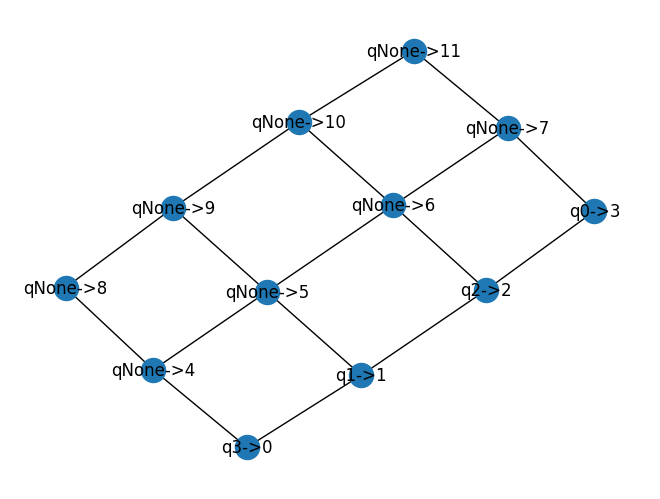

In [68]:
# @title Simlpe 2D circuit

_hardware = nx.grid_2d_graph(3,4)
_hardware = nx.relabel_nodes(_hardware,
    {n: i for i, n in enumerate(_hardware.nodes)})
#draw_hardware_graph(_hardware)
_cuccaro4 = QuantumCircuit(4)
_cuccaro4.cx(0,1)
_cuccaro4.cx(1,2)
_cuccaro4.cx(2,3)
_cuccaro4.cx(2,1)

#_mapping = map_circuit(_cuccaro4, _hardware)
_mapping = {Qubit(QuantumRegister(4, 'q'), 0): 3,
              Qubit(QuantumRegister(4, 'q'), 1): 1,
              Qubit(QuantumRegister(4, 'q'), 2): 2,
             Qubit(QuantumRegister(4, 'q'), 3): 0}
draw_mapping(_hardware, _mapping)
validate_mapping(_cuccaro4, _hardware, _mapping)
score_mapping(_cuccaro4, _hardware, _mapping)
print('PASS: Valid circuit mapping')

Your mapping score is 6, better than the worst possible of 96.
PASS: Valid circuit mapping


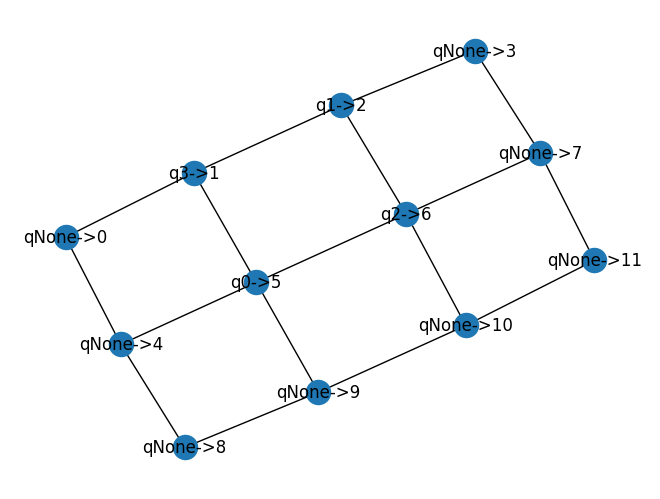

In [69]:
# @title Complex 2D circuit

_hardware = nx.grid_2d_graph(3,4)
_hardware = nx.relabel_nodes(_hardware,
    {n: i for i, n in enumerate(_hardware.nodes)})
#draw_hardware_graph(_hardware)
_cuccaro4 = QuantumCircuit(4)
_cuccaro4.cx(0,1)
_cuccaro4.cx(0,2)
_cuccaro4.cx(0,2)
_cuccaro4.cx(0,3)
_cuccaro4.cx(0,1)
_cuccaro4.cx(1,2)
_cuccaro4.cx(0,2)
_cuccaro4.cx(1,2)
_cuccaro4.cx(0,1)
_cuccaro4.cx(1,2)
_cuccaro4.cx(0,3)
_cuccaro4.cx(1,2)


#_mapping = map_circuit(_cuccaro4, _hardware)
# _mapping = {Qubit(QuantumRegister(4, 'q'), 0): 3,
#               Qubit(QuantumRegister(4, 'q'), 1): 1,
#               Qubit(QuantumRegister(4, 'q'), 2): 2,
#              Qubit(QuantumRegister(4, 'q'), 3): 0}

_mapping = {Qubit(QuantumRegister(4, 'q'), 0): 5,
              Qubit(QuantumRegister(4, 'q'), 1): 2,
              Qubit(QuantumRegister(4, 'q'), 2): 6,
             Qubit(QuantumRegister(4, 'q'), 3): 1}

draw_mapping(_hardware, _mapping)
validate_mapping(_cuccaro4, _hardware, _mapping)
score_mapping(_cuccaro4, _hardware, _mapping)
print('PASS: Valid circuit mapping')

AssertionError: Not all qubits (or too many) were mapped to hardware

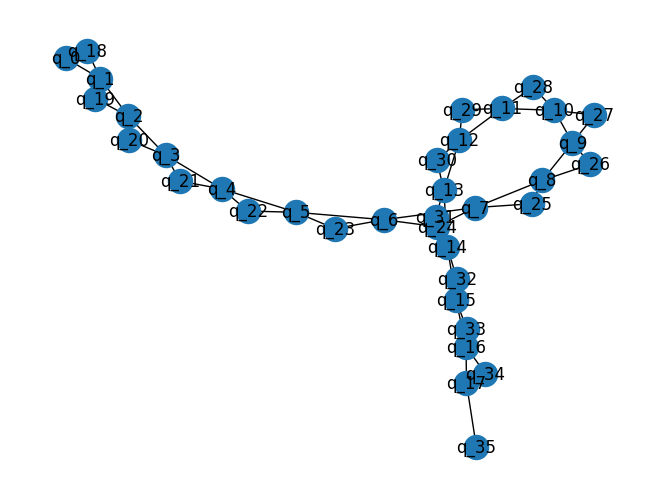

In [70]:
_hardware = nx.grid_2d_graph(6, 6)
_hardware = nx.relabel_nodes(_hardware,
    {n: i for i, n in enumerate(_hardware.nodes)})
#_cuccaro36 = decomposed_adder_circuit(36)
_cuccaro36 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[36];\ncx q[1],q[18];\ncx q[1],q[0];\nh q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[18];\ncx q[0],q[18];\nrz(pi/4) q[0];\nrz(-pi/4) q[18];\ncx q[0],q[18];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[0],q[18];\ncx q[2],q[19];\ncx q[2],q[1];\nh q[2];\ncx q[19],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[19],q[2];\nrz(pi/4) q[19];\nrz(-pi/4) q[2];\ncx q[1],q[2];\ncx q[1],q[19];\nrz(pi/4) q[1];\nrz(-pi/4) q[19];\ncx q[1],q[19];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\ncx q[1],q[19];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[3],q[20];\ncx q[3],q[2];\nh q[3];\ncx q[20],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[20],q[3];\nrz(pi/4) q[20];\nrz(-pi/4) q[3];\ncx q[2],q[3];\ncx q[2],q[20];\nrz(pi/4) q[2];\nrz(-pi/4) q[20];\ncx q[2],q[20];\nrz(2.6375741) q[20];\nrx(pi) q[20];\nrz(2.6375741) q[20];\ncx q[2],q[20];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\ncx q[4],q[21];\ncx q[4],q[3];\nh q[4];\ncx q[21],q[4];\nrz(-pi/4) q[4];\ncx q[3],q[4];\nrz(pi/4) q[4];\ncx q[21],q[4];\nrz(pi/4) q[21];\nrz(-pi/4) q[4];\ncx q[3],q[4];\ncx q[3],q[21];\nrz(-pi/4) q[21];\nrz(pi/4) q[3];\ncx q[3],q[21];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\ncx q[3],q[21];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[5],q[22];\ncx q[5],q[4];\nh q[5];\ncx q[22],q[5];\nrz(-pi/4) q[5];\ncx q[4],q[5];\nrz(pi/4) q[5];\ncx q[22],q[5];\nrz(pi/4) q[22];\nrz(-pi/4) q[5];\ncx q[4],q[5];\ncx q[4],q[22];\nrz(-pi/4) q[22];\nrz(pi/4) q[4];\ncx q[4],q[22];\nrz(2.6375741) q[22];\nrx(pi) q[22];\nrz(2.6375741) q[22];\ncx q[4],q[22];\nrz(-5*pi/4) q[5];\nrx(pi/2) q[5];\nrz(pi/2) q[5];\ncx q[6],q[23];\ncx q[6],q[5];\nh q[6];\ncx q[23],q[6];\nrz(-pi/4) q[6];\ncx q[5],q[6];\nrz(pi/4) q[6];\ncx q[23],q[6];\nrz(pi/4) q[23];\nrz(-pi/4) q[6];\ncx q[5],q[6];\ncx q[5],q[23];\nrz(-pi/4) q[23];\nrz(pi/4) q[5];\ncx q[5],q[23];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\ncx q[5],q[23];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[7],q[24];\ncx q[7],q[6];\nh q[7];\ncx q[24],q[7];\nrz(-pi/4) q[7];\ncx q[6],q[7];\nrz(pi/4) q[7];\ncx q[24],q[7];\nrz(pi/4) q[24];\nrz(-pi/4) q[7];\ncx q[6],q[7];\ncx q[6],q[24];\nrz(-pi/4) q[24];\nrz(pi/4) q[6];\ncx q[6],q[24];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\ncx q[6],q[24];\nrz(-5*pi/4) q[7];\nrx(pi/2) q[7];\nrz(pi/2) q[7];\ncx q[8],q[25];\ncx q[8],q[7];\nh q[8];\ncx q[25],q[8];\nrz(-pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[8];\ncx q[25],q[8];\nrz(pi/4) q[25];\nrz(-pi/4) q[8];\ncx q[7],q[8];\ncx q[7],q[25];\nrz(-pi/4) q[25];\nrz(pi/4) q[7];\ncx q[7],q[25];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\ncx q[7],q[25];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[9],q[26];\ncx q[9],q[8];\nh q[9];\ncx q[26],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[26],q[9];\nrz(pi/4) q[26];\nrz(-pi/4) q[9];\ncx q[8],q[9];\ncx q[8],q[26];\nrz(-pi/4) q[26];\nrz(pi/4) q[8];\ncx q[8],q[26];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\ncx q[8],q[26];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[10],q[27];\ncx q[10],q[9];\nh q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\ncx q[9],q[10];\nrz(pi/4) q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(pi/4) q[27];\ncx q[9],q[10];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[9],q[27];\nrz(-pi/4) q[27];\nrz(pi/4) q[9];\ncx q[9],q[27];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\ncx q[9],q[27];\ncx q[11],q[28];\ncx q[11],q[10];\nh q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(pi/4) q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nrz(pi/4) q[28];\ncx q[10],q[28];\nrz(pi/4) q[10];\nrz(-pi/4) q[28];\ncx q[10],q[28];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\ncx q[10],q[28];\ncx q[12],q[29];\ncx q[12],q[11];\nh q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(pi/4) q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nrz(pi/4) q[29];\ncx q[11],q[29];\nrz(pi/4) q[11];\nrz(-pi/4) q[29];\ncx q[11],q[29];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[11],q[29];\ncx q[13],q[30];\ncx q[13],q[12];\nh q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(pi/4) q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[30];\ncx q[12],q[30];\nrz(pi/4) q[12];\nrz(-pi/4) q[30];\ncx q[12],q[30];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[12],q[30];\ncx q[14],q[31];\ncx q[14],q[13];\nh q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(pi/4) q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nrz(pi/4) q[31];\ncx q[13],q[31];\nrz(pi/4) q[13];\nrz(-pi/4) q[31];\ncx q[13],q[31];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[13],q[31];\ncx q[15],q[32];\ncx q[15],q[14];\nh q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\nrz(pi/4) q[32];\ncx q[14],q[32];\nrz(pi/4) q[14];\nrz(-pi/4) q[32];\ncx q[14],q[32];\nrz(2.6375741) q[32];\nrx(pi) q[32];\nrz(2.6375741) q[32];\ncx q[14],q[32];\ncx q[16],q[33];\ncx q[16],q[15];\nh q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nrz(pi/4) q[33];\ncx q[15],q[33];\nrz(pi/4) q[15];\nrz(-pi/4) q[33];\ncx q[15],q[33];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[15],q[33];\ncx q[17],q[34];\ncx q[17],q[16];\nh q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(pi/4) q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(-5*pi/4) q[17];\nrx(pi/2) q[17];\nrz(pi/2) q[17];\nrz(pi/4) q[34];\ncx q[16],q[34];\nrz(pi/4) q[16];\nrz(-pi/4) q[34];\ncx q[16],q[34];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\ncx q[16],q[34];\ncx q[17],q[35];\nh q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(pi/4) q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(-5*pi/4) q[17];\nrx(pi/2) q[17];\nrz(pi/2) q[17];\nrz(pi/4) q[34];\ncx q[16],q[34];\nrz(pi/4) q[16];\nrz(-pi/4) q[34];\ncx q[16],q[34];\ncx q[17],q[16];\nh q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nrz(pi/4) q[33];\ncx q[15],q[33];\nrz(pi/4) q[15];\nrz(-pi/4) q[33];\ncx q[15],q[33];\ncx q[16],q[15];\nh q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\nrz(pi/4) q[32];\ncx q[14],q[32];\nrz(pi/4) q[14];\nrz(-pi/4) q[32];\ncx q[14],q[32];\ncx q[15],q[14];\nh q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(pi/4) q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nrz(pi/4) q[31];\ncx q[13],q[31];\nrz(pi/4) q[13];\nrz(-pi/4) q[31];\ncx q[13],q[31];\ncx q[14],q[13];\nh q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(pi/4) q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[30];\ncx q[12],q[30];\nrz(pi/4) q[12];\nrz(-pi/4) q[30];\ncx q[12],q[30];\ncx q[13],q[12];\nh q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(pi/4) q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nrz(pi/4) q[29];\ncx q[11],q[29];\nrz(pi/4) q[11];\nrz(-pi/4) q[29];\ncx q[11],q[29];\ncx q[12],q[11];\nh q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(pi/4) q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nrz(pi/4) q[28];\ncx q[10],q[28];\nrz(pi/4) q[10];\nrz(-pi/4) q[28];\ncx q[10],q[28];\ncx q[11],q[10];\nh q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\ncx q[11],q[28];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[12],q[29];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[13],q[30];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[14],q[31];\nrz(2.6375741) q[32];\nrx(pi) q[32];\nrz(2.6375741) q[32];\ncx q[15],q[32];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[16],q[33];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\ncx q[17],q[34];\ncx q[9],q[10];\nrz(pi/4) q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(pi/4) q[27];\ncx q[9],q[10];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[9],q[27];\nrz(-pi/4) q[27];\nrz(pi/4) q[9];\ncx q[9],q[27];\ncx q[10],q[9];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\ncx q[10],q[27];\nh q[9];\ncx q[26],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[26],q[9];\nrz(pi/4) q[26];\nrz(-pi/4) q[9];\ncx q[8],q[9];\ncx q[8],q[26];\nrz(-pi/4) q[26];\nrz(pi/4) q[8];\ncx q[8],q[26];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[9],q[8];\nh q[8];\ncx q[25],q[8];\nrz(-pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[8];\ncx q[25],q[8];\nrz(pi/4) q[25];\nrz(-pi/4) q[8];\ncx q[7],q[8];\ncx q[7],q[25];\nrz(-pi/4) q[25];\nrz(pi/4) q[7];\ncx q[7],q[25];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[8],q[7];\nh q[7];\ncx q[24],q[7];\nrz(-pi/4) q[7];\ncx q[6],q[7];\nrz(pi/4) q[7];\ncx q[24],q[7];\nrz(pi/4) q[24];\nrz(-pi/4) q[7];\ncx q[6],q[7];\ncx q[6],q[24];\nrz(-pi/4) q[24];\nrz(pi/4) q[6];\ncx q[6],q[24];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\nrz(-5*pi/4) q[7];\nrx(pi/2) q[7];\nrz(pi/2) q[7];\ncx q[7],q[6];\nh q[6];\ncx q[23],q[6];\nrz(-pi/4) q[6];\ncx q[5],q[6];\nrz(pi/4) q[6];\ncx q[23],q[6];\nrz(pi/4) q[23];\nrz(-pi/4) q[6];\ncx q[5],q[6];\ncx q[5],q[23];\nrz(-pi/4) q[23];\nrz(pi/4) q[5];\ncx q[5],q[23];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[6],q[5];\nh q[5];\ncx q[22],q[5];\nrz(-pi/4) q[5];\ncx q[4],q[5];\nrz(pi/4) q[5];\ncx q[22],q[5];\nrz(pi/4) q[22];\nrz(-pi/4) q[5];\ncx q[4],q[5];\ncx q[4],q[22];\nrz(-pi/4) q[22];\nrz(pi/4) q[4];\ncx q[4],q[22];\nrz(2.6375741) q[22];\nrx(pi) q[22];\nrz(2.6375741) q[22];\nrz(-5*pi/4) q[5];\nrx(pi/2) q[5];\nrz(pi/2) q[5];\ncx q[5],q[4];\nh q[4];\ncx q[21],q[4];\nrz(-pi/4) q[4];\ncx q[3],q[4];\nrz(pi/4) q[4];\ncx q[21],q[4];\nrz(pi/4) q[21];\nrz(-pi/4) q[4];\ncx q[3],q[4];\ncx q[3],q[21];\nrz(-pi/4) q[21];\nrz(pi/4) q[3];\ncx q[3],q[21];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[4],q[3];\nh q[3];\ncx q[20],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[20],q[3];\nrz(pi/4) q[20];\nrz(-pi/4) q[3];\ncx q[2],q[3];\ncx q[2],q[20];\nrz(pi/4) q[2];\nrz(-pi/4) q[20];\ncx q[2],q[20];\nrz(2.6375741) q[20];\nrx(pi) q[20];\nrz(2.6375741) q[20];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\ncx q[3],q[2];\nh q[2];\ncx q[19],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[19],q[2];\nrz(pi/4) q[19];\nrz(-pi/4) q[2];\ncx q[1],q[2];\ncx q[1],q[19];\nrz(pi/4) q[1];\nrz(-pi/4) q[19];\ncx q[1],q[19];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[2],q[1];\nh q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[18];\ncx q[0],q[18];\nrz(pi/4) q[0];\nrz(-pi/4) q[18];\ncx q[0],q[18];\ncx q[1],q[0];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[1],q[18];\ncx q[2],q[19];\ncx q[3],q[20];\ncx q[4],q[21];\ncx q[5],q[22];\ncx q[6],q[23];\ncx q[7],q[24];\ncx q[8],q[25];\ncx q[9],q[26];\n')
draw_interaction_graph(interaction_graph_from_circuit(_cuccaro36))
#_mapping = map_circuit(_cuccaro36, _hardware)
ig = interaction_graph_from_circuit(_cuccaro36)
nodeWeights = {}
for node1,node2 in ig.edges:
    print(node1)
    print(node2)
    print(ig[node1][node2]['weight'])
    if node1._index < node2._index: nodeInteraction = (node1._index, node2._index)
    else: nodeInteraction = (node2._index, node1._index)
    nodeWeights[nodeInteraction] = ig[node1][node2]['weight']

validate_mapping(_cuccaro36, _hardware, _mapping)
_score, _worst = score_mapping(_cuccaro36, _hardware, _mapping)
assert _worst == 5220, 'internal error'
assert _score <= 1600, 'score is above 1600, try improving the mapping by placing pairs of qubits with many CNOTs close together'
print('PASS: Score is under 1600 (see if you can beat our solution of 210)')